# Giới thiệu <a class="anchor" id="intro"></a>

Trong lĩnh vực học máy, luôn có một sự đánh đổi giữa **tính giải thích** (explainability) và **khả năng dự đoán** (predictability). Những mô hình mạnh mẽ thường trở nên cực kỳ khó diễn giải đối với khán giả chung và các bên liên quan.

Để giải quyết vấn đề này, tôi muốn viết sổ tay này như một hướng dẫn thực hành về cách sử dụng **SHAP** (SHapley Additive exPlanations) - một phương pháp tuyệt vời để giải thích đầu ra của mô hình học máy. **SHAP** sử dụng một cách tiếp cận dựa trên lý thuyết trò chơi để gán giá trị quan trọng cho từng đặc trưng trong mô hình.

**SHAP** giúp diễn giải tác động của một giá trị cụ thể của một đặc trưng nhất định so với dự đoán mà chúng ta sẽ đưa ra nếu đặc trưng đó có một giá trị cơ sở (baseline). Chúng đặc biệt hữu ích khi trả lời các câu hỏi như sau:

* James dành **33 phút mỗi ngày** để thực hiện các hoạt động thể chất có cường độ trung bình, trong khi một người Mỹ trung bình dành **18 phút mỗi ngày**. Tuổi thọ trung bình ở Mỹ là khoảng **77,5 năm**, nhưng mô hình hồi quy của chúng ta dự đoán rằng James sẽ sống đến **101,6 năm**. Sự khác biệt trong dự đoán này cụ thể được thúc đẩy bởi thời gian tập thể dục hàng ngày của James (**33 phút**) thay vì mức cơ sở (**18 phút**) bao nhiêu?

* Giá trị của một công ty khởi nghiệp kỳ lân **XYZ** là **2,3 tỷ USD**, trong khi giá trị trung vị của một công ty khởi nghiệp khi IPO thường vào khoảng **1 tỷ USD** dựa trên phân tích vốn hóa thị trường. Tỷ lệ thành công IPO trung bình là khoảng **20%**, nhưng mô hình của chúng ta dự đoán rằng xác suất thành công của **IPO của XYZ** là **56%**. Sự khác biệt này cụ thể bị tác động bởi định giá cao của **XYZ (2,3 tỷ USD)** so với giá trị cơ sở **(1 tỷ USD)** bao nhiêu?

Kaggle đã cung cấp một hướng dẫn về _Giải thích mô hình học máy_ (Machine Learning Explainability), trong đó có giới thiệu về [giá trị SHAP](http://www.kaggle.com/code/dansbecker/shap-values/tutorial) trong một bài học. Bạn nên đọc hướng dẫn đó để hiểu các khái niệm cơ bản và ứng dụng của **SHAP**. Tuy nhiên, hướng dẫn đó có thể đã được phát triển từ khá lâu, và thư viện `shap` đã được cập nhật nhiều lần kể từ đó. Do đó, các đoạn mã trong hướng dẫn đó đã trở nên lỗi thời đáng kể và quá cơ bản trong cách sử dụng. Nếu bạn cố gắng chạy các đoạn mã đó trong **IDE** hoặc sổ tay (**notebook**) của riêng mình, bạn có thể sẽ gặp vô số lỗi và vấn đề cần xử lý.

Sau nhiều ngày gỡ lỗi và nghiên cứu thư viện `shap`, tôi nghĩ rằng tôi đã giải quyết được tất cả các vấn đề. Vì vậy, tôi muốn tạo ra sổ tay này như một phiên bản **mới** của hướng dẫn dành cho những người mới bắt đầu trong lĩnh vực này, cũng như để tôi có thể xem lại trong tương lai.

Mặc dù thư viện `shap` có thể sẽ tiếp tục được cập nhật trong tương lai, tôi tin rằng những ghi chú của tôi có thể phục vụ như một hướng dẫn về các **thực tiễn tốt nhất** của các tính năng hữu ích nhất của **SHAP**, ít nhất là trong thời điểm hiện tại.

In [56]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Mục Lục
* [Giới Thiệu](#intro)
* [Dự Án 1: SHAP Values cho Phân Loại](#p1)
    * [Dự đoán Cầu thủ xuất sắc nhất trận](#mom)
    * [Tải Dữ Liệu và Huấn Luyện Mô Hình](#load1)
    * [Xác định Quan Sát Cần Giải Thích](#identify1)
    * [Tạo Đối Tượng Giải Thích](#create1)
    * [Tính Toán SHAP Values](#calculate1)
    * [Hiển Thị SHAP của Một Dự Đoán Cụ Thể](#single1)
        * [Biểu Đồ Force](#force1)
        * [Biểu Đồ Waterfall](#water1)
        * [Biểu Đồ Thanh Cục Bộ](#localbar1)
    * [Hiển Thị SHAP của Tất Cả Các Dự Đoán](#all1)
        * [Biểu Đồ Thanh Toàn Cục](#globalbar1)
        * [Biểu Đồ Beeswarm](#bee1)
        * [Biểu Đồ Violin](#violin1)
* [Dự Án 2: SHAP Values cho Hồi Quy](#p2)
    * [Dự đoán Giá Nhà](#house)
    * [Tải Dữ Liệu và Huấn Luyện Mô Hình](#load2)
    * [Xác định Quan Sát Cần Giải Thích](#identify2)
    * [Tạo Đối Tượng Giải Thích](#create2)
    * [Tính Toán SHAP Values](#calculate2)
    * [Hiển Thị SHAP của Tất Cả Các Dự Đoán](#all2)
        * [Biểu Đồ Thanh Toàn Cục](#globalbar2)
        * [Biểu Đồ Beeswarm](#bee2)
        * [Biểu Đồ Violin](#violin2)
    * [Hiển Thị SHAP của Một Dự Đoán Cụ Thể](#single2)
        * [Biểu Đồ Thanh Cục Bộ](#localbar2)
        * [Biểu Đồ Waterfall](#water2)
        * [Biểu Đồ Force](#force2)
    * [Bonus: Biểu Đồ Phụ Thuộc Một Phần](#pdp2)

# Dự Án 1: SHAP Values cho Phân Loại <a class="anchor"  id="p1"></a>
## Dự đoán Cầu thủ Xuất sắc Nhất Trận <a class="anchor"  id="mom"></a>

Ví dụ đầu tiên sử dụng mô hình phân loại `RandomForestClassifier` để dự đoán liệu một đội bóng có giành được danh hiệu _Cầu thủ xuất sắc nhất trận_ (*Man of the Match*) trong trận đấu bóng đá tại World Cup FIFA 2018 hay không.  
Thông tin dữ liệu có thể được tìm thấy trên trang dataset của [Dự đoán Cầu thủ Xuất sắc Nhất Trận FIFA 2018](https://www.kaggle.com/datasets/mathan/fifa-2018-match-statistics).

## Tải Dữ Liệu và Huấn Luyện Mô Hình (Dự Án 1) <a class="anchor"  id="load1"></a>

In [57]:
data = pd.read_csv('FIFA 2018 Statistics.csv')

# Create a Boolean target variable
y = (data['Man of the Match'] == 'Yes')

# Keep only numeric features for simplicity
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

# Train the model with only training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

## Xác định Quan Sát Cần Giải Thích (Dự Án 1) <a class="anchor"  id="identify1"></a>

Ví dụ, trong World Cup này, nếu bạn đặc biệt quan tâm đến trận đấu giữa Bỉ và Pháp, bạn có thể xác định chính xác chỉ mục và vị trí của nó trong tập dữ liệu để tính toán SHAP values cho dự đoán của mô hình.

In [58]:
game_name = 'the game Belgium vs France'
row_index_in_data = data.loc[(data.Team == 'Belgium') & (data.Opponent == 'France')].index[0]
print('Row index of {} in the whole dataset is {}.'.format(game_name, row_index_in_data))

if row_index_in_data in val_X.index:
    print('Luckily, {} is in the validation dataset.\n'.format(game_name))
else:
    print('Unfortunately, {} is not in the validation dataset.\nChoose another game to interpret or re-split/reshuffle the train/validation datasets.\n'.format(game_name))

Row index of the game Belgium vs France in the whole dataset is 121.
Luckily, the game Belgium vs France is in the validation dataset.



Hoặc, chúng ta có thể kiểm tra các trận đấu có trong bộ dữ liệu kiểm tra `val_X` trước, và sau đó quyết định trận đấu nào chúng ta muốn giải thích.

In [59]:
print(data.loc[val_X.index, ['Team', 'Opponent']].head(8))
# Using .head(8) method to list the indices and team names of the first 8 games in val_X for example.

        Team        Opponent
121  Belgium          France
104   Brazil          Mexico
55    Mexico  Korea Republic
56   Germany          Sweden
33     Egypt          Russia
118   Russia         Croatia
122  Croatia         England
35   Morocco        Portugal


Như đã thấy trong mẫu trên, chỉ mục của trận đấu Bỉ vs Pháp là **121**. Vì vậy, bạn có thể đặt giá trị `row_index_in_data = 121` một cách thủ công.

In [60]:
row_to_show = val_X.index.get_loc(row_index_in_data)
print('The integer location (iloc) of {} in val_X dataframe is {}.'.format(game_name, row_to_show))
print('So, after calculating SHAP values on val_X later, the index {} will also be its corresponding location in the shap_values_val_X array.'.format(row_to_show))

The integer location (iloc) of the game Belgium vs France in val_X dataframe is 0.
So, after calculating SHAP values on val_X later, the index 0 will also be its corresponding location in the shap_values_val_X array.


Với số chỉ mục `row_to_show`, chúng ta có thể chọn dữ liệu (tất cả giá trị đặc trưng) của trận đấu mà chúng ta quan tâm (Bỉ vs Pháp) từ dataframe `val_X`.

In [61]:
data_for_prediction_series = val_X.iloc[row_to_show]
print('The shape of data_for_prediction_series is {}, and its type is {}.'.format(data_for_prediction_series.shape, type(data_for_prediction_series)))

The shape of data_for_prediction_series is (18,), and its type is <class 'pandas.core.series.Series'>.


Như đã thấy ở trên, việc sử dụng `loc`/`iloc` để chọn một hàng duy nhất từ dataframe sẽ tạo ra một đối tượng `Series` (một cột duy nhất), thay vì một dataframe với một hàng duy nhất.

Chúng ta cần chuyển đổi `data_for_prediction_series` thành một dataframe với một hàng duy nhất, chứa tên các cột gốc, để tính toán dự đoán và SHAP values sau này.

In [62]:
data_for_prediction = data_for_prediction_series.to_frame().transpose()
print('The shape of data_for_prediction is {}, and its type is {}.'.format(data_for_prediction.shape, type(data_for_prediction)))

The shape of data_for_prediction is (1, 18), and its type is <class 'pandas.core.frame.DataFrame'>.


Bằng cách sử dụng các phương thức `to_frame()` và `transpose()`, chúng ta dễ dàng chuyển đổi `Series` với 18 hàng `data_for_prediction_series` thành một `DataFrame` với 1 hàng và 18 cột `data_for_prediction`.

Trong [hướng dẫn cũ](https://www.kaggle.com/code/dansbecker/shap-values?scriptVersionId=126573591&cellId=5), phương pháp `.values.reshape(1, -1)` đã được sử dụng để thay đổi hình dạng của cột thành một mảng với một hàng. Nếu sử dụng phương pháp này, mã sẽ như sau:
```python
data_for_prediction_array = data_for_prediction_series.values.reshape(1, -1)
```
Phương pháp này hầu như hoạt động, nhưng nó sẽ gây ra một cảnh báo khi thực hiện dự đoán:
_UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names_.

Để tránh nhầm lẫn, tôi khuyên bạn nên sử dụng các phương thức `to_frame()` và `transpose()` như đã trình bày ở trên.

In [63]:
belgium_pred_prob = my_model.predict_proba(data_for_prediction)
print('The output of predict_proba method: {}.'.format(belgium_pred_prob))
print('It tells us the predicted probability for the target value to be 0 is {}, while its probability to be 1 is {} in this single observation.'.format(belgium_pred_prob[0][0], belgium_pred_prob[0][1]))

The output of predict_proba method: [[0.62 0.38]].
It tells us the predicted probability for the target value to be 0 is 0.62, while its probability to be 1 is 0.38 in this single observation.


So the predicted probability of Belgium to win _Man of the Match_ in the game vs France is 0.38.

## Create An Explainer Object (Project 1) <a class="anchor"  id="create1"></a>

In [64]:
explainer = shap.TreeExplainer(my_model, data=train_X)
# data=train_X is optional

Trong mã code trên, `shap.TreeExplainer` sử dụng thuật toán Tree SHAP, đây là một phương pháp nhanh và chính xác để ước tính SHAP values cho các mô hình cây quyết định và các bộ mô hình cây.

Tham số tùy chọn `data=train_X` đặt tập dữ liệu nền để sử dụng cho việc tích hợp các đặc trưng. Cũng có thể thiết lập `data=val_X`. Cá nhân tôi nghĩ rằng việc sử dụng `data=train_X` là hợp lý hơn, vì bạn huấn luyện mô hình (và explainer) trên dữ liệu huấn luyện và dự đoán (và giải thích) trên dữ liệu kiểm tra.

Ngoài ra, chúng ta có thể sử dụng `shap.Explainer`:
```python
explainer = shap.Explainer(my_model, masker=train_X)
# masker=train_X is optional
```
`shap.Explainer` là giao diện giải thích chính của thư viện `shap`, và nó có thể giải thích bất kỳ mô hình học máy nào hoặc hàm python bằng cách kết hợp mô hình và masker.

Như đã đề cập trong [hướng dẫn cũ](https://www.kaggle.com/code/dansbecker/shap-values?scriptVersionId=126573591&cellId=10), thư viện `shap` có các explainer cho mọi loại mô hình. Ví dụ:

* `LinearExplainer`: Một phương pháp đơn giản và hiệu quả cho các mô hình tuyến tính, nơi SHAP values có thể được tính toán trực tiếp từ các hệ số của mô hình.
* `DeepExplainer`: Được xây dựng cho các mô hình học sâu, đặc biệt là mạng nơ-ron.
* `GradientExplainer`: Rất hữu ích cho các mô hình có thể phân biệt được, bao gồm các mô hình học sâu.
* `KernelExplainer`: Một explainer đa năng có thể sử dụng với bất kỳ loại mô hình nào. Nó sử dụng phương pháp dựa trên kernel để xấp xỉ SHAP values khi bạn không có quyền truy cập vào cấu trúc nội bộ của mô hình. Nó có thể tốn nhiều tài nguyên tính toán, vì vậy nếu cần tính toán nhanh hơn, bạn có thể cân nhắc sử dụng `GradientExplainer` hoặc các explainer khác.

## Tính Toán SHAP Values (Dự Án 1) <a class="anchor"  id="calculate1"></a>

In [65]:
shap_values_val_X = explainer(val_X, check_additivity=False)
shap_values = explainer(data_for_prediction, check_additivity=False)

print('The shape of shap_values_val_X array is {}.'.format(shap_values_val_X.shape))
print('The shape of shap_values array is {}.'.format(shap_values.shape))

The shape of shap_values_val_X array is (32, 18, 2).
The shape of shap_values array is (1, 18, 2).


Như đã tạo trong mã code trên, cả `shap_values_val_X` và `shap_values` đều là các đối tượng `Explanation` được tạo ra bởi `explainer`.

* `shap_values_val_X` tính toán SHAP values cho tất cả các quan sát trong tập dữ liệu `val_X`, vì vậy kích thước của nó tương ứng với **32** quan sát, **18** đặc trưng và **2** giá trị mục tiêu có thể có (0 = "thua", 1 = "thắng");
* `shap_values` tính toán SHAP values cho một quan sát duy nhất (trận đấu bóng đá Bỉ vs Pháp) chứa trong `data_for_prediction`, vì vậy kích thước của nó tương ứng với **1** quan sát, **18** đặc trưng và **2** giá trị mục tiêu có thể có.

Dành cho người mới bắt đầu, tôi khuyên bạn nên thiết lập tham số `check_additivity=False` như đã thấy ở trên. Nếu chúng ta không bao gồm nó trong dấu ngoặc sau `explainer`, có thể gặp phải lỗi thông báo như sau:

> `shap.utils._exceptions.ExplainerError: Additivity check failed in TreeExplainer!` Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was Number A, while the model output was Number B. If this difference is acceptable you can set check_additivity=False to disable this check.

> Lỗi `shap.utils._exceptions.ExplainerError: Additivity check failed in TreeExplainer!` xảy ra khi có sự không khớp giữa tổng các SHAP values và đầu ra của mô hình cho một mẫu cụ thể.
> Thông báo lỗi yêu cầu kiểm tra xem ma trận dữ liệu bạn đã cung cấp cho explainer có cùng kích thước với dữ liệu mà mô hình đã được huấn luyện không. Nếu kích thước dữ liệu là chính xác nhưng lỗi vẫn tiếp diễn, bạn có thể báo cáo lỗi này trên GitHub.
>Lỗi này xảy ra vì đối với một trong các mẫu, tổng của các SHAP values là **Số A**, trong khi đầu ra của mô hình lại là **Số B**. Nếu sự khác biệt này là chấp nhận được, bạn có thể tắt kiểm tra additivity bằng cách thiết lập `check_additivity=False` như sau:
```python
explainer = shap.TreeExplainer(model, check_additivity=False)
```


Vì là các đối tượng `Explanation`, cả `shap_values_val_X` và `shap_values` đều có ba thuộc tính: `.values`, `.base_values` và `.data`.
* Thuộc tính `.data` là một bản sao của dữ liệu đầu vào;
* Thuộc tính `.base_values` là giá trị kỳ vọng của mục tiêu, hoặc giá trị mục tiêu trung bình của tất cả dữ liệu huấn luyện;
* Thuộc tính `.values` là **SHAP** values cho mỗi ví dụ.

Nếu chúng ta chỉ quan tâm đến **SHAP** values (như có trong `.values`), chúng ta có thể sử dụng phương thức `explainer.shap_values()` thay vì `explainer()`. Tuy nhiên, các đối tượng `Explanation` lại tiện lợi hơn khi được sử dụng trực tiếp trong việc triển khai các hình ảnh trực quan SHAP như dưới đây.

## Hiển Thị SHAP của Một Dự Đoán Cụ Thể (Dự Án 1) <a class="anchor"  id="single1"></a>
Để giải thích một quan sát cụ thể bằng SHAP values, chúng ta tính toán và hiển thị SHAP value cho mỗi đặc trưng trong quan sát đó, điều này cơ bản cho chúng ta biết mỗi đặc trưng đã đóng góp bao nhiêu vào dự đoán của mô hình cho điểm dữ liệu cụ thể này, giúp chúng ta hiểu được đặc trưng nào có ảnh hưởng lớn nhất đến kết quả và liệu chúng có đẩy dự đoán về phía giá trị cao hơn hay thấp hơn.

### Biểu Đồ Force <a class="anchor"  id="force1"></a>
Một cách phổ biến để hiển thị SHAP values cho một quan sát cụ thể là sử dụng biểu đồ force.

#### Mã Code để Tạo Biểu Đồ Force
Trong [hướng dẫn cũ](https://www.kaggle.com/code/dansbecker/shap-values?scriptVersionId=126573591&cellId=9), giảng viên đã viết một số mã như sau:
```python
shap.force_plot(explainer.expected_value[1], shap_values.values[1], data_for_prediction)
```
Có thể đây là cách cũ để triển khai biểu đồ force, vì tôi đã gặp phải một số lỗi khi cố gắng sao chép kết quả vào IDE của mình. Tôi đoán thư viện `shap` đã đơn giản hóa mã nguồn cho các biểu đồ trực quan trong các phiên bản mới hơn, và tôi thấy cách tiện lợi nhất để tạo biểu đồ force hiện nay sẽ là:

In [66]:
shap.initjs()
shap.plots.force(shap_values_val_X[row_to_show, :, 1])

Trong đoạn mã trên, `shap.initjs()` là một hàm trong thư viện `shap` được sử dụng để khởi tạo các hình ảnh trực quan bằng JavaScript trong môi trường notebook (ví dụ như Jupyter notebooks). Nó không áp dụng hoặc hữu ích khi chạy trong IDE (ví dụ như Pycharm).

Như đã biết, `shap_values_val_X` chứa một mảng 3 chiều với kích thước (32, 18, 2), và `row_to_show` xác định vị trí cụ thể của trận đấu Bỉ vs Pháp trong mảng `shap_values_val_X` theo chỉ mục đầu tiên. Vì vậy, chúng ta sử dụng `shap_values_val_X[row_to_show, :, 1]` để chọn chính xác các SHAP values mà chúng ta muốn hiển thị trong biểu đồ.

Ngoài ra, chúng ta nên sử dụng `shap_values_val_X[row_to_show, :, 1]` thay vì `shap_values_val_X[row_to_show, :, 0]` vì cái sau biểu thị xác suất của giá trị mục tiêu là 0, trong khi cái trước chỉ ra xác suất giá trị mục tiêu là 1. Như đã giải thích trong [hướng dẫn cũ](https://www.kaggle.com/code/dansbecker/shap-values?scriptVersionId=126573591&cellId=8), chúng ta thường nghĩ về dự đoán trong bối cảnh dự đoán kết quả tích cực, và trong trường hợp này là khả năng Bỉ **thắng** giải thưởng _Cầu thủ xuất sắc nhất trận_.

Một cách khác để tạo biểu đồ force này là sử dụng `shap_values` thay vì `shap_values_val_X`. Như đã trình bày trên, `shap_values` chỉ chứa SHAP values cho một quan sát duy nhất (trận đấu Bỉ vs Pháp) từ `data_for_prediction`, vì vậy kích thước của nó là (1, 18, 2). Do đó, chúng ta không cần phải xác định chỉ mục đầu tiên sau `shap_values` nữa.

In [67]:
shap.plots.force(shap_values[:, :, 1])

#### Giải Thích Biểu Đồ Force

Bạn có thể thấy rằng hai biểu đồ force được tạo ra ở trên là giống hệt nhau. Điều này là bởi vì chúng đang cố gắng kể cùng một câu chuyện về xác suất dự đoán của Bỉ để giành giải _Cầu thủ xuất sắc nhất trận_ trong trận đấu với Pháp.

Giá trị được làm nổi bật **0.38** là dự đoán cho quan sát này. Nói cách khác, mô hình dự đoán rằng chỉ có 38% khả năng Bỉ sẽ giành giải _Cầu thủ xuất sắc nhất trận_. Giá trị cơ sở là khoảng 50% (hiển thị là 0.4933 trong biểu đồ), đó là khả năng trung bình của một đội (trong cột `Team`) để giành giải _Cầu thủ xuất sắc nhất trận_ trong tập dữ liệu huấn luyện.

Các giá trị đặc trưng đẩy xác suất dự đoán cao hơn (với SHAP values dương) được hiển thị bằng màu đỏ ở phía bên trái, trong khi các giá trị đặc trưng đẩy xác suất dự đoán thấp hơn (với SHAP values âm) được hiển thị bằng màu xanh lam ở phía bên phải, như thể chúng đang cạnh tranh với nhau, vì vậy tên gọi "biểu đồ force". Kích thước trực quan của mỗi thanh cho thấy độ lớn của tác động từ đặc trưng tương ứng. Nếu bạn trừ tổng chiều dài các thanh đỏ khỏi chiều dài các thanh xanh lam, bạn sẽ có khoảng cách từ giá trị cơ sở đến đầu ra (0.38).

Vậy tại sao trong trận đấu này, cơ hội Bỉ giành giải _Cầu thủ xuất sắc nhất trận_ (0.38) lại thấp hơn nhiều so với trung bình (0.49)?
* Tác động lớn nhất đến từ **Goal Scored** là 0, gần như làm giảm xác suất dự đoán đi 20 điểm phần trăm;
* Mặc dù **Pass Accuracy** của Bỉ lên tới 90%, điều này đã đẩy xác suất giành giải cao hơn đáng kể, nhưng vẫn không đủ để bù đắp tác động từ việc không ghi bàn;
* Chỉ thực hiện 9 **Attempts** với chỉ 3 cú sút **On Target** trong trận đấu cũng làm giảm khả năng Bỉ giành giải.

#### Lưu Biểu Đồ Force

Mặc dù việc hiển thị biểu đồ force trong notebook là rất đơn giản, nhưng đây không phải là giải pháp thực tế nhất trong thế giới thực. Một vấn đề kỹ thuật là biểu đồ có thể bị cắt nếu nó vượt quá lề của notebook khi quá rộng so với chiều rộng của trang, như biểu đồ ở trên. Nếu bạn là một nhà phân tích kinh doanh, tư vấn viên hoặc nhà nghiên cứu, bạn có thể muốn xuất và lưu biểu đồ này về máy tính, sau đó nhúng nó vào powerpoint, báo cáo, bài báo hoặc trang web của riêng bạn. Đây là cách thực hiện:

In [68]:
force_plot_fifa = shap.plots.force(shap_values_val_X[row_to_show, :, 1], show=False)
shap.save_html('force_plot_fifa.htm', force_plot_fifa)

Khi chạy đoạn mã trên, biểu đồ force đã được lưu trong thư mục đầu ra dưới tên `force_plot_fifa.htm`. (Bạn có thể kiểm tra và tải nó về dưới tab Output của notebook Kaggle này.)

Điều này đặc biệt hữu ích nếu bạn đang chạy mã trong bất kỳ IDE nào (ví dụ như PyCharm). Và tất nhiên, bạn có thể có cùng một tệp đầu ra bằng cách sử dụng `shap_values` trong mã sau:
```python
force_plot_fifa = shap.plots.force(shap_values[:, :, 1], show=False)
```
Về lý thuyết, chúng ta cũng có thể lưu biểu đồ force dưới dạng tệp PDF về máy tính bằng `matplotlib`. Đây là một lựa chọn tốt để lưu các biểu đồ khác (sẽ được thảo luận dưới đây), nhưng tôi cá nhân không khuyến khích điều này cho biểu đồ force:

In [69]:
plt.close()

In [70]:
plt.figure(figsize=(40, 10))
shap.plots.force(shap_values_val_X[row_to_show, :, 1], matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('force_plot_fifa.pdf')
plt.close()

Tham số `matplotlib` trong dấu ngoặc của `shap.plots.force` xác định liệu có sử dụng đầu ra mặc định bằng Javascript hay không, hoặc sử dụng đầu ra ít phát triển hơn từ `matplotlib` cho biểu đồ force. Giá trị mặc định của nó là `False` vì, như bạn có thể thấy trong thư mục đầu ra, đầu ra từ `matplotlib` không tinh tế và hoàn thiện như phiên bản `htm` của biểu đồ force. Sử dụng `matplotlib=True` ở đây chỉ hữu ích trong các tình huống khi việc hiển thị Javascript/HTML gặp khó khăn cực kỳ.

### Biểu Đồ Waterfall <a class="anchor"  id="water1"></a>

Biểu đồ waterfall là cách tôi ưa thích để hiển thị SHAP values cho một quan sát cụ thể, được thể hiện theo một cách khác.

#### Mã Code để Tạo Biểu Đồ Waterfall

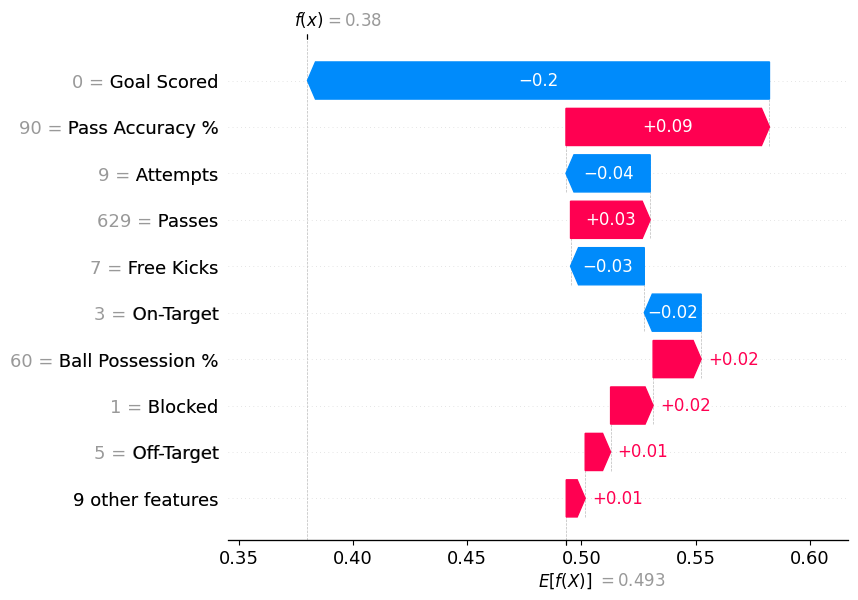

In [71]:
shap.plots.waterfall(shap_values_val_X[row_to_show, :, 1], show=True, max_display=10)

Khác với biểu đồ force, hầu hết các biểu đồ `shap` (ví dụ: biểu đồ waterfall) không cần `shap.initjs()` để khởi tạo các hình ảnh trực quan bằng JavaScript trong môi trường notebook. Chúng ta chỉ cần tham số `show=True` theo mặc định để xem trực tiếp.

Vì có 18 đặc trưng trong mô hình dự đoán, chúng ta có thể chỉ muốn biết 10 đặc trưng có ảnh hưởng lớn nhất với các SHAP values lớn nhất để đưa ra dự đoán này. Do đó, chúng ta thiết lập `max_display=10` khi tạo biểu đồ waterfall này.

#### Giải Thích Biểu Đồ Waterfall
Tổng quan, biểu đồ waterfall hiển thị cùng một thông tin như biểu đồ force ở trên. Tuy nhiên, ở đây chúng ta có thể thấy rõ hơn độ lớn của từng SHAP value và cách tổng của tất cả các SHAP values bằng với sự chênh lệch giữa dự đoán _f(x)_ (0.38) cho quan sát duy nhất và giá trị kỳ vọng _E[f(x)]_ (0.493) cho tình huống trung bình trong dữ liệu huấn luyện.

#### Lưu Biểu Đồ Waterfall
Khác với biểu đồ force, việc lưu biểu đồ waterfall bằng `matplotlib` là dễ dàng và hiệu quả.

In [72]:
plt.figure()
shap.plots.waterfall(shap_values_val_X[row_to_show, :, 1], show=False, max_display=10)
plt.tight_layout()
plt.savefig('waterfall_fifa.pdf')
plt.close()

Khi chạy đoạn mã trên, biểu đồ waterfall đã được lưu trong thư mục đầu ra dưới tên `waterfall_fifa.pdf`. (Bạn có thể kiểm tra và tải về dưới tab Output của notebook Kaggle này.) Một lần nữa, điều này đặc biệt hữu ích nếu bạn đang chạy mã trong bất kỳ IDE nào (ví dụ như PyCharm).

Điều quan trọng cần nhớ là phải thiết lập tham số `show=False` khi lưu biểu đồ waterfall. Nếu không, tệp đầu ra sẽ bị trống.

### Biểu Đồ Thanh Cục Bộ <a class="anchor"  id="localbar1"></a>
Biểu đồ thanh có thể được sử dụng trên các quan sát đơn lẻ để phân tích các hiệu ứng cục bộ, tức là các ảnh hưởng theo từng trường hợp.

#### Mã Code để Tạo Biểu Đồ Thanh Cục Bộ

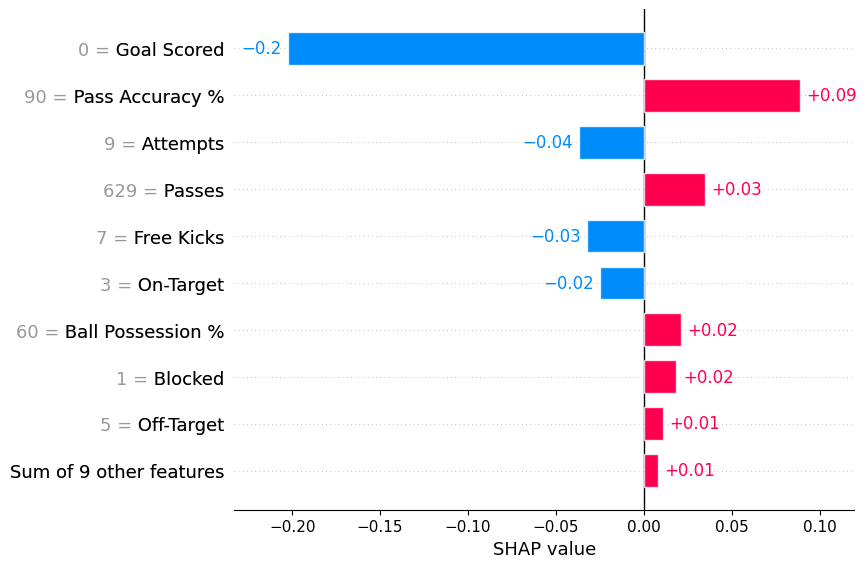

In [73]:
shap.plots.bar(shap_values_val_X[row_to_show, :, 1], show=True, max_display=10)

#### Giải Thích Biểu Đồ Thanh Cục Bộ
Tương tự như biểu đồ force và biểu đồ waterfall, biểu đồ thanh này cũng cho chúng ta thấy các đặc trưng chính ảnh hưởng đến dự đoán của một quan sát đơn lẻ, và độ lớn của SHAP value cho từng đặc trưng.

#### Lưu Biểu Đồ Thanh Cục Bộ

In [74]:
plt.figure()
shap.plots.bar(shap_values_val_X[row_to_show, :, 1], show=False, max_display=10)
plt.tight_layout()
plt.savefig('local_bar_fifa.pdf')
plt.close()

Khi chạy đoạn mã trên, biểu đồ thanh cục bộ đã được lưu trong thư mục đầu ra dưới tên `local_bar_fifa.pdf`. Bạn có thể kiểm tra và tải về nó dưới tab Output của notebook Kaggle này, như thể bạn tìm thấy tệp đầu ra trong thư mục cục bộ khi chạy mã trong một IDE (ví dụ như PyCharm) trên máy tính của bạn.

Một lần nữa, chúng ta phải thiết lập tham số `show=False` khi lưu biểu đồ thanh cục bộ. Nếu không, tệp đầu ra sẽ bị trống.

## Hiển Thị SHAP của Tất Cả Các Dự Đoán (Dự Án 1) <a class="anchor"  id="all1"></a>

Bên cạnh việc giải thích một quan sát đơn lẻ, đôi khi chúng ta cũng muốn nhìn thấy bức tranh tổng thể. Việc đánh giá các ảnh hưởng tổng thể của các đặc trưng trong một bối cảnh rộng hơn, thay vì chỉ tập trung vào một điểm dữ liệu đơn lẻ, là rất có ý nghĩa. Để phân tích các ảnh hưởng toàn cầu của các đặc trưng lên các giá trị mục tiêu dự đoán, chúng ta có thể sử dụng các biểu đồ sau.

### Biểu Đồ Thanh Toàn Cục <a class="anchor"  id="globalbar1"></a>
Mặc dù biểu đồ thanh toàn cục có thể không hấp dẫn bằng các biểu đồ khác dưới đây, nhưng nó có thể truyền đạt một thông điệp rõ ràng về thông tin cơ bản nhất về các đặc trưng nào có ảnh hưởng lớn nhất đến mô hình, xét một cách tổng thể.

#### Mã Code để Tạo Biểu Đồ Thanh Toàn Cục

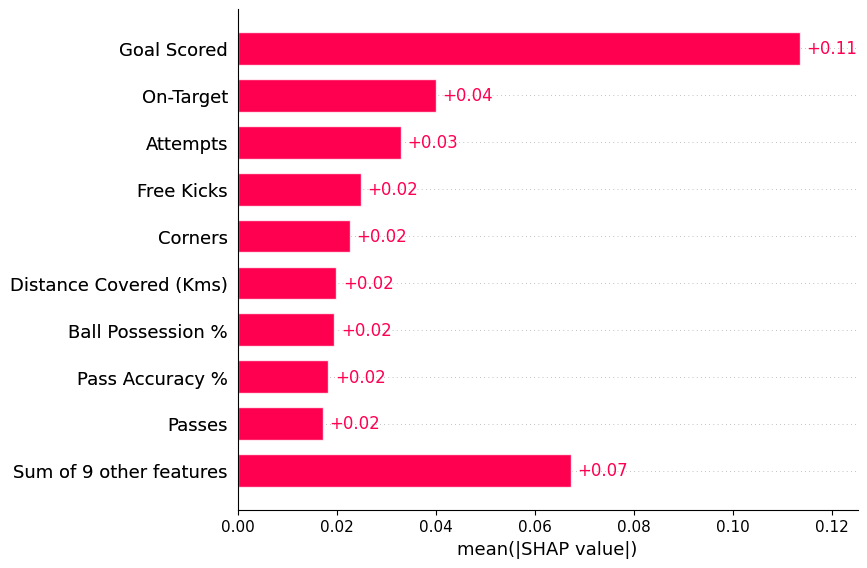

In [75]:
shap.plots.bar(shap_values_val_X[:, :, 1], show=True, max_display=10)

Lưu ý rằng chúng ta không còn sử dụng `shap_values_val_X[row_to_show, :, 1]` như trong biểu đồ thanh cục bộ nữa. Thay vào đó, chúng ta sử dụng `shap_values_val_X[:, :, 1]` ở đây vì chúng ta muốn biểu đồ thanh toàn cục hiển thị mức độ ảnh hưởng tổng thể của các đặc trưng khác nhau trong dự đoán của mô hình được thực hiện cho toàn bộ bộ dữ liệu kiểm tra `val_X`.

#### Giải Thích Biểu Đồ Thanh Toàn Cục
Như đã giải thích trong nhãn trục x, biểu đồ thanh toàn cục chỉ tính đến các **SHAP values tuyệt đối** trong mỗi dự đoán, bất kể đặc trưng có ảnh hưởng đến dự đoán theo hướng tích cực hay tiêu cực.

Rõ ràng, **Goal Scored** là yếu tố quan trọng nhất với một khoảng cách lớn, quyết định liệu một đội bóng có khả năng giành giải _Cầu thủ xuất sắc nhất trận_ hay không. Mô hình cũng xem xét **On-Target**, **Attempts** và các đặc trưng khác khi đưa ra dự đoán, nhưng chúng ít ảnh hưởng hơn.

#### Lưu Biểu Đồ Thanh Toàn Cục

In [76]:
plt.figure()
shap.plots.bar(shap_values_val_X[:, :, 1], show=False, max_display=10)
plt.tight_layout()
plt.savefig('global_bar_fifa.pdf')
plt.close()

Khi chạy đoạn mã trên, biểu đồ thanh toàn cục đã được lưu trong thư mục đầu ra dưới tên `global_bar_fifa.pdf`. Bạn có thể tìm thấy nó dưới tab Output của notebook Kaggle này. Và một lần nữa, khi lưu biểu đồ về máy, chúng ta phải thiết lập tham số `show=False`.

Trong tài liệu chính thức của [shap.plots.bar](https://shap.readthedocs.io/en/latest/generated/shap.plots.bar.html), có một tham số `ax` cho `Axes` của `matplotlib`, chỉ ra đối tượng `Axes` mà biểu đồ sẽ được vẽ lên. Sử dụng tham số này, chúng ta có thể tạo và lưu biểu đồ theo cách này:
```python
fig, ax = plt.subplots(figsize=(12, 10))
shap.plots.bar(shap_values_val_X[:, :, 1], show=False, max_display=10, ax=ax)
plt.tight_layout()
plt.savefig('global_bar_fifa.pdf')
plt.close()
```
Điều này gần như không hoạt động trong IDE của tôi (PyCharm), nhưng khi tôi chạy nó trên Kaggle notebook, lại gây ra lỗi `TypeError: bar() got an unexpected keyword argument 'ax'`. Tôi nghĩ rằng Kaggle chưa cài đặt phiên bản mới nhất của thư viện `shap`, hoặc thư viện `shap` chưa hoàn toàn tương thích với Kaggle notebook hay thư viện `matplotlib`. Các mã được giữ lại đây cho bạn tham khảo. Tôi hy vọng rằng thư viện `shap` sẽ được cải thiện trong các phiên bản tương lai.

### Biểu Đồ Beeswarm <a class="anchor"  id="bee1"></a>

Mặc dù biểu đồ force, biểu đồ waterfall và biểu đồ thanh cục bộ trên trông có vẻ cung cấp nhiều thông tin, nhưng các SHAP values được hiển thị trong những biểu đồ đó chỉ hợp lệ cho một quan sát duy nhất (tức là trận đấu Bỉ vs Pháp). Các SHAP values sẽ thay đổi khi giải thích các điểm dữ liệu khác trong tập kiểm tra `val_X`. Để tổng hợp toàn bộ phân phối của SHAP values cho mỗi đặc trưng, sẽ rất tiện lợi khi sử dụng biểu đồ beeswarm.

#### Mã Code để Tạo Biểu Đồ Beeswarm

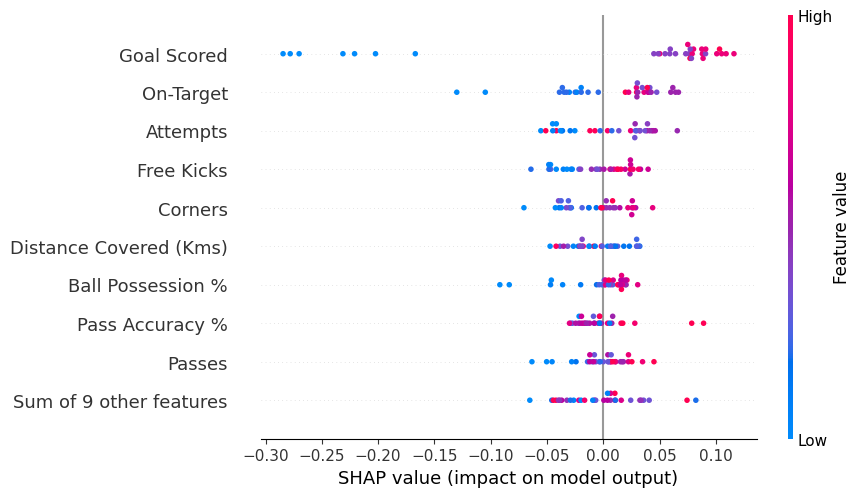

In [77]:
shap.plots.beeswarm(shap_values_val_X[:, :, 1], show=True, max_display=10)

Một lần nữa, chúng ta sử dụng `shap_values_val_X[:, :, 1]` thay vì `shap_values_val_X[row_to_show, :, 1]` ở đây vì chúng ta muốn trích xuất tất cả các SHAP values hiển thị cách các đặc trưng ảnh hưởng đến các dự đoán của mô hình cho tất cả các trận đấu trong toàn bộ tập dữ liệu kiểm tra `val_X`.

#### Giải Thích Biểu Đồ Beeswarm

Giống như trong biểu đồ thanh toàn cục, các đặc trưng được sắp xếp theo độ lớn của tác động của chúng lên dự đoán trong biểu đồ beeswarm. Nhưng ngoài điều đó, chúng ta giờ đây có thể thấy cách các giá trị cao hơn và thấp hơn của mỗi đặc trưng ảnh hưởng đến kết quả dự đoán khác nhau.

Trục hoành đại diện cho giá trị SHAP, trong khi màu sắc của mỗi điểm chỉ ra giá trị đặc trưng trong một quan sát. Như được minh họa trong chú giải, màu đỏ chỉ ra giá trị đặc trưng cao hơn, trong khi màu xanh lam chỉ ra giá trị đặc trưng thấp hơn. Theo một cách nào đó, điều này giống như việc vẽ một biểu đồ thanh cục bộ cho mỗi quan sát, sau đó biên soạn tất cả các biểu đồ thanh cục bộ đó thành biểu đồ beeswarm mang lại thông tin giống nhau.

Các điểm đỏ cho **Goal Scored** chủ yếu nằm ở phía bên phải, với các điểm xanh lam ở bên trái. Điều này có nghĩa là số bàn thắng ghi được cao hơn thường có giá trị SHAP cao hơn, làm tăng khả năng đội bóng giành giải _Cầu thủ xuất sắc nhất trận_, như mô hình dự đoán.

Tình huống trở nên phức tạp hơn với **Distance Covered (Kms)** trong biểu đồ, vì các điểm đỏ và xanh lam của nó pha trộn với nhau. Điều này có thể cho chúng ta biết rằng việc chạy quãng đường dài hơn không nhất thiết dẫn đến cơ hội giành chiến thắng cao hơn. Đôi khi, một đội phải chạy nhiều vì họ bị chiến thuật của đối thủ chi phối và phải vật lộn một cách thụ động trong việc phòng thủ.

#### Lưu Biểu Đồ Beeswarm

In [78]:
plt.figure()
shap.plots.beeswarm(shap_values_val_X[:, :, 1], show=False, max_display=10)
plt.tight_layout()
plt.savefig('beeswarm_fifa.pdf')
plt.close()

Tôi muốn lưu ý rằng việc sử dụng `plt.tight_layout()` ở trên là một cách tốt để ngăn các SHAP plots vẽ ra ngoài giới hạn trang.

Khi chạy đoạn mã trên, biểu đồ beeswarm đã được lưu trong thư mục đầu ra dưới tên `beeswarm_fifa.pdf`. Và một lần nữa, khi lưu biểu đồ về máy, nhớ thiết lập tham số `show=False`.

Tính đến thời điểm hiện tại, `shap.plots.beeswarm()` không thể nhận tham số `ax` chút nào, ngay cả trong IDE của tôi (PyCharm). Vì vậy, nếu bạn thử vẽ biểu đồ trên đối tượng `Axes` bằng cách sử dụng `ax=ax` như sau:
```python
fig, ax = plt.subplots(figsize=(12, 10))
shap.plots.beeswarm(shap_values_val_X[:, :, 1], show=False, max_display=10, ax=ax)
plt.tight_layout()
plt.savefig('beeswarm_fifa.pdf')
plt.close()
```
Nó sẽ gây ra lỗi nói rằng `TypeError: beeswarm() got an unexpected keyword argument 'ax'`. Tôi phải nói rằng thư viện `shap` chưa thực sự tương thích với thư viện `matplotlib` để tạo ra các hình vẽ, và tôi hy vọng họ sẽ có thể làm việc với nhau một cách trơn tru hơn trong các phiên bản tương lai.

### Biểu Đồ Violin <a class="anchor"  id="violin1"></a>

Biểu đồ violin là một dạng biến thể của biểu đồ beeswarm, hiển thị cùng một thông tin nhưng theo một cách thẩm mỹ hơn.

#### Mã Code để Tạo Biểu Đồ Violin

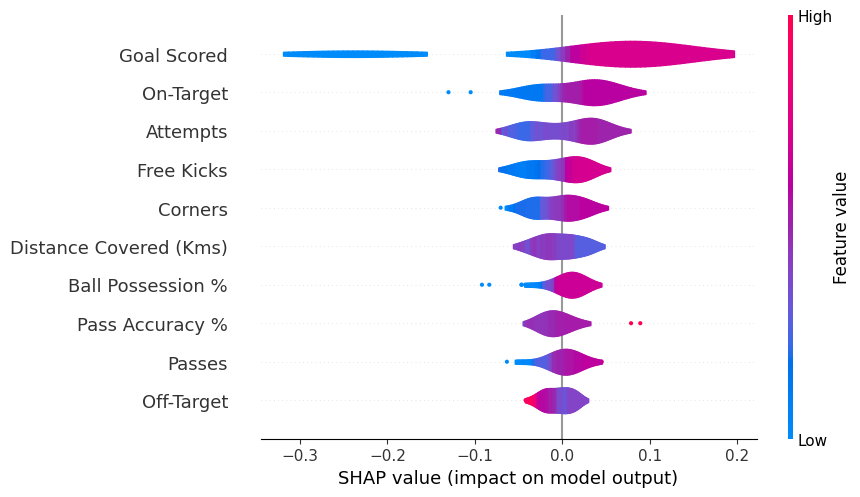

In [79]:
shap.plots.violin(shap_values_val_X[:, :, 1], show=True, max_display=10)

Các mã code ở trên rất giống với các mã của biểu đồ beeswarm, vì vậy dễ dàng hiểu được. Một cách cũ để tạo biểu đồ violin sẽ là
```python
shap.summary_plot(shap_values_val_X[:, :, 1], show=True, max_display=10, plot_type='violin')
```
, nhưng tôi thích phương pháp mới ở trên.

#### Lưu Biểu Đồ Violin

In [80]:
plt.figure()
shap.plots.violin(shap_values_val_X[:, :, 1], show=False, max_display=10)
plt.tight_layout()
plt.savefig('violin_fifa.pdf')
plt.close()

Khi chạy đoạn mã trên, biểu đồ violin đã được lưu trong thư mục đầu ra dưới tên `violin_fifa.pdf`.

# Dự Án 2: SHAP Values cho Hồi Quy <a class="anchor"  id="p2"></a>
## Dự Đoán Giá Trị Nhà <a class="anchor"  id="house"></a>

Ví dụ thứ hai sử dụng mô hình hồi quy `RandomForestRegressor` để dự đoán giá trị nhà trung bình cho các quận tại California.

Thông tin về dữ liệu có thể được tìm thấy trong Hướng dẫn Người dùng của bộ dữ liệu [7.2.7. Bộ Dữ liệu Nhà ở California](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

Theo Hướng dẫn Người dùng, biến mục tiêu là giá trị nhà trung bình cho các quận tại California, được biểu diễn theo hàng trăm nghìn đô la ($100,000). Bộ dữ liệu này được lấy từ cuộc điều tra dân số Hoa Kỳ năm 1990, sử dụng một hàng cho mỗi nhóm khu vực điều tra dân số. Một nhóm khu vực là đơn vị địa lý nhỏ nhất mà Cục Điều tra Dân số Hoa Kỳ công bố dữ liệu mẫu (một nhóm khu vực thường có dân số từ 600 đến 3,000 người).

Các đặc trưng chúng ta sẽ sử dụng là:
* **MedInc**: thu nhập trung bình trong nhóm khu vực
* **HouseAge**: tuổi nhà trung bình trong nhóm khu vực
* **AveRooms**: số phòng trung bình mỗi hộ gia đình
* **AveBedrms**: số phòng ngủ trung bình mỗi hộ gia đình
* **Population**: dân số nhóm khu vực
* **AveOccup**: số thành viên trung bình mỗi hộ gia đình
* **Latitude**: vĩ độ nhóm khu vực
* **Longitude**: kinh độ nhóm khu vực

## Tải Dữ Liệu và Huấn Luyện Mô Hình (Dự Án 2) <a class="anchor"  id="load2"></a>

In [81]:
dataset = fetch_california_housing(as_frame=True)
X = dataset['data']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1)

# Train the model with only training data
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Chúng ta thiết lập `test_size=0.01` ở đây vì đây là một bộ dữ liệu rất lớn với tổng cộng 20,640 quan sát. Nếu tập kiểm tra quá lớn, quá trình `shap` giải thích và tính toán SHAP values cho nó sẽ mất rất nhiều thời gian.

## Xác Định Quan Sát Để Giải Thích (Dự Án 2) <a class="anchor"  id="identify2"></a>
Hãy tưởng tượng bạn có kế hoạch chuyển đến khu trung tâm thành phố Los Angeles, và bạn muốn biết những yếu tố nào đang làm tăng hoặc giảm giá trị nhà ở đó. Bằng cách tìm kiếm trên Google Map, bạn phát hiện ra rằng phạm vi vĩ độ và kinh độ cho khu trung tâm Los Angeles là khoảng từ 34.144°N đến 33.9695°N và từ 118.348°W đến 118.128°W. Vậy chúng ta hãy kiểm tra xem các nhóm khu vực nào ở khu trung tâm Los Angeles có trong tập kiểm tra.

In [82]:
print(X_test.loc[(X_test.Latitude > 33.9695) & (X_test.Latitude < 34.144) & (X_test.Longitude > -118.348) & (X_test.Longitude < -118.128), ['Latitude', 'Longitude']])

      Latitude  Longitude
7157     34.04    -118.16
7385     33.97    -118.24
4282     34.10    -118.32
4281     34.09    -118.32
4909     34.02    -118.27
6857     34.06    -118.16
4641     34.06    -118.30
4173     34.10    -118.23
5044     33.97    -118.33
7316     33.98    -118.19
4546     34.02    -118.20
4211     34.10    -118.25
4405     34.08    -118.24
7268     33.98    -118.22
4785     34.03    -118.32


Sau khi tìm kiếm các vị trí địa lý trên Google Map và đọc các đánh giá phổ biến trực tuyến, bạn cảm thấy đặc biệt quan tâm đến một khu phố có tên "Elysian Heights", với vĩ độ phía Bắc 34.10 và kinh độ phía Tây -118.25. Bạn có thể trực tiếp tìm thấy chỉ số hàng của nó là 4211 ở trên, hoặc bạn cũng có thể lưu chỉ số hàng này dưới tên `index_original`:

In [83]:
neighborhood = 'Elysian Heights'
index_original = X_test.loc[(X_test.Latitude == 34.10) & (X_test.Longitude == -118.25)].index[0]
print('The original row index of {} neighborhood in the dataset is {}.'.format(neighborhood, index_original))

The original row index of Elysian Heights neighborhood in the dataset is 4211.


Với chỉ số hàng gốc, việc lấy vị trí số nguyên (iloc) của khu phố Elysian Heights trong `X_test` sẽ hữu ích hơn:

In [84]:
iloc_test = X_test.index.get_loc(index_original)
print('The integer location (iloc) of {} in X_test dataframe is {}.'.format(neighborhood, iloc_test))
print('So, after calculating SHAP values on X_test later, the index {} will also be its corresponding location in the shap_values_test array.'.format(iloc_test))

The integer location (iloc) of Elysian Heights in X_test dataframe is 187.
So, after calculating SHAP values on X_test later, the index 187 will also be its corresponding location in the shap_values_test array.


Với `iloc_test` đã được tính toán ở trên, chúng ta có thể chọn dữ liệu (tất cả các giá trị đặc trưng) của khu phố Elysian Heights từ dataframe `X_test`.

In [85]:
neighborhood_series = X_test.iloc[iloc_test]
print('The shape of neighborhood_series is {}, and its type is {}.'.format(neighborhood_series.shape, type(neighborhood_series)))

neighborhood_row = neighborhood_series.to_frame().transpose()
print('The shape of neighborhood_row is {}, and its type is {}.'.format(neighborhood_row.shape, type(neighborhood_row)))

The shape of neighborhood_series is (8,), and its type is <class 'pandas.core.series.Series'>.
The shape of neighborhood_row is (1, 8), and its type is <class 'pandas.core.frame.DataFrame'>.


Như đã minh họa trong đoạn mã trên, chúng ta đầu tiên chọn dữ liệu của khu phố Elysian Heights dưới dạng đối tượng `Series` có tên là `neighborhood_series` với 8 hàng và 1 cột, và sau đó chuyển đổi nó thành đối tượng `DataFrame` có tên là `neighborhood_row` với 1 hàng và 8 cột. DataFrame này chứa các tên cột gốc sẽ hữu ích cho việc tính toán dự đoán và SHAP values sau này.

In [86]:
neighborhood_pred = model.predict(neighborhood_row)
print('The output of model predict method: {}.'.format(neighborhood_pred))
print('It tells us the predicted median house value in Elysian Heights is ${:,}.'.format(neighborhood_pred[0] * 100000))

The output of model predict method: [3.0948003].
It tells us the predicted median house value in Elysian Heights is $309,480.03.


Như đã tính toán ở trên, mô hình hồi quy của chúng ta dự đoán giá trị trung vị của ngôi nhà trong khu dân cư Elysian Heights là khoảng $309,480.

## Tạo Một Đối Tượng Explainer (Dự án 2) <a class="anchor"  id="create2"></a>

In [87]:
explainer = shap.TreeExplainer(model, data=X_train)
# data=X_train is optional

Giống như trình giải thích trong Dự Án 1, `shap.TreeExplainer` sử dụng các thuật toán Tree SHAP, là một phương pháp nhanh chóng và chính xác để ước tính SHAP values cho các mô hình cây và tập hợp các cây. Vì chúng ta đã sử dụng `RandomForestRegressor()` để xây dựng mô hình, `shap.TreeExplainer` là lựa chọn tốt nhất trong trường hợp này. Tham số tùy chọn `data=X_train` thiết lập bộ dữ liệu nền.

Ngoài ra, chúng ta có thể sử dụng `shap.Explainer`:
```python
explainer = shap.Explainer(model, masker=X_train)
# masker=X_train is optional
```
Nhưng phương pháp này không hiệu quả so với `shap.TreeExplainer` trong trường hợp này. Thêm chú thích về chủ đề này có thể được tìm thấy trong Dự Án 1 ở trên.

## Tính Toán SHAP Values (Dự Án 2) <a class="anchor" id="calculate2"></a>

In [88]:
shap_values_test = explainer(X_test, check_additivity=False)
shap_values_case = explainer(neighborhood_row, check_additivity=False)

print('The shape of shap_values_test array is {}.'.format(shap_values_test.shape))
print('The shape of shap_values_case array is {}.'.format(shap_values_case.shape))

100%|===================| 206/207 [00:19<00:00]        

The shape of shap_values_test array is (207, 8).
The shape of shap_values_case array is (1, 8).


Tương tự như Dự án 1, cả `shap_values_test` và `shap_values_case` ở đây đều là các đối tượng `Explanation` được tạo ra bởi explainer.

Tuy nhiên, bạn có thể đã nhận thấy rằng các mảng giá trị SHAP chứa trong `shap_values_val_X` và `shap_values` từ Dự án 1 là các mảng **3D**, trong khi `shap_values_test` và `shap_values_case` trong Dự án 2 chỉ có các mảng **2D**. Đây là sự khác biệt điển hình giữa các bài toán phân loại và hồi quy. Chiều thứ ba trong các mảng giá trị SHAP đối với mô hình phân loại (Dự án 1) giúp phân biệt ảnh hưởng của đặc trưng lên xác suất dự đoán của giá trị mục tiêu là 0 và ảnh hưởng của đặc trưng lên xác suất dự đoán của giá trị mục tiêu là 1 (ví dụ: trong Dự án 1, xác suất dự đoán thua giải _Man of the Match_ và xác suất dự đoán thắng giải _Man of the Match_). Đối với mô hình hồi quy trong Dự án 2, chúng ta không còn cần chiều thứ ba nữa, vì chúng ta chỉ muốn biết ảnh hưởng của đặc trưng lên giá trị mục tiêu dự đoán.

* `shap_values_test` tính toán giá trị SHAP cho tất cả các quan sát trong bộ dữ liệu `X_test`, vì vậy kích thước của nó tương ứng với **207** quan sát và **8** đặc trưng;
* `shap_values_case` tính toán giá trị SHAP cho một quan sát duy nhất (nhóm khu dân cư ở Elysian Heights) có trong `neighborhood_row`, vì vậy kích thước của nó tương ứng với **1** quan sát và **8** đặc trưng.

Một lần nữa, tôi đặt tham số `check_additivity=False` như đã hiển thị ở trên để tránh các lỗi không cần thiết.

Là các đối tượng `Explanation`, cả `shap_values_test` và `shap_values_case` đều có ba thuộc tính: `.values`, `.base_values` và `.data`. Mặc dù chúng ta quan tâm nhiều hơn đến thuộc tính `.values` chứa chính xác giá trị SHAP cho mỗi ví dụ, tôi thấy tiện lợi hơn khi sử dụng trực tiếp các đối tượng `Explanation` khi tạo các hình ảnh trực quan SHAP. Một lần nữa, có thêm chú thích về chủ đề này có thể được tìm thấy trong Dự án 1 ở trên.

## Hiển thị SHAP của Tất cả Các Dự đoán (Dự án 2) <a class="anchor"  id="all2"></a>
Lần này, chúng ta sẽ đánh giá tác động tổng thể của các đặc trưng trong bộ kiểm tra trước. Để phân tích tác động toàn cầu của các đặc trưng lên các giá trị mục tiêu dự đoán, chúng ta có thể sử dụng các biểu đồ sau.

### Biểu đồ Cột Toàn Cầu <a class="anchor"  id="globalbar2"></a>
Một lần nữa, biểu đồ cột toàn cầu cung cấp cho chúng ta thông tin cơ bản về các đặc trưng có ảnh hưởng lớn nhất trong mô hình.

#### Mã để Tạo Biểu đồ Cột Toàn Cầu

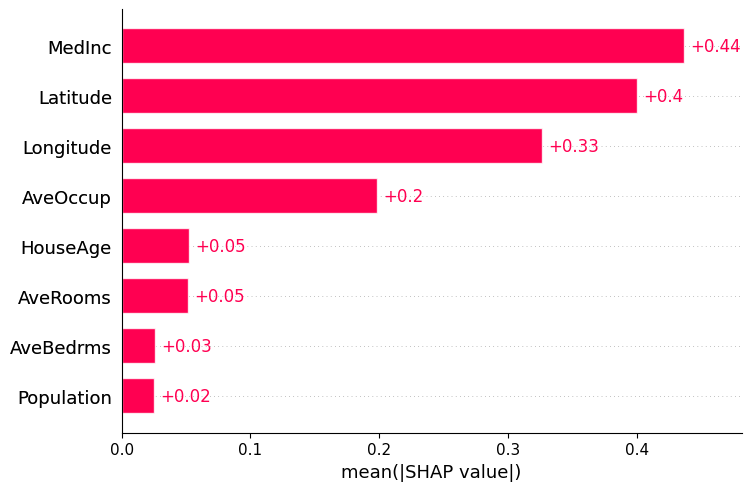

In [89]:
shap.plots.bar(shap_values_test, show=True, max_display=10)

Xin lưu ý rằng chúng ta đang sử dụng trực tiếp `shap_values_test` trong `shap.plots.bar()` mà không sử dụng chỉ mục ở đây. Trong Dự án 1, chúng ta đã sử dụng `shap_values_val_X[:, :, 1]` trong `shap.plots.bar()` vì chúng ta muốn chỉ hiển thị ảnh hưởng của đặc trưng trong việc đẩy giá trị mục tiêu về 1 thay vì ảnh hưởng của nó trong việc đẩy giá trị mục tiêu về 0. Chúng ta không cần phải lo lắng về vấn đề này trong Dự án 2 vì giá trị mục tiêu của nó là giá trị nhà được dự đoán bởi mô hình hồi quy của chúng ta.

#### Giải thích Biểu đồ Cột Toàn Cầu

Một lần nữa, như đã giải thích trong nhãn trục x, biểu đồ cột toàn cầu chỉ xem xét các giá trị SHAP **tuyệt đối** trong mỗi dự đoán, bất kể liệu đặc trưng ảnh hưởng đến dự đoán theo hướng tích cực hay tiêu cực. Vì vậy, chúng ta chỉ có thể sử dụng biểu đồ cột toàn cầu để hiển thị mức độ quan trọng tổng thể của các đặc trưng khác nhau trong dự đoán của mô hình.

Theo biểu đồ cột toàn cầu, thu nhập trung bình **MedInc** là yếu tố quan trọng nhất đối với giá trị nhà trung vị trong một nhóm khu dân cư, theo sau là vị trí địa lý của nhóm khu dân cư được chỉ ra bởi **Latitude** và **Longitude**. **Population** (dân số nhóm khu dân cư) và **AveBedrms** (số phòng ngủ trung bình mỗi hộ gia đình) có xu hướng là những yếu tố ít ảnh hưởng nhất.

#### Lưu Biểu đồ Cột Toàn Cầu

In [90]:
plt.figure()
shap.plots.bar(shap_values_test, show=False, max_display=10)
plt.tight_layout()
plt.savefig('global_bar_house.pdf')
plt.close()

Bằng cách chạy khối mã trên, biểu đồ cột toàn cầu đã được lưu trong thư mục đầu ra dưới tên `global_bar_house.pdf`, bạn có thể tìm thấy nó trong tab Output của notebook Kaggle này. Và một lần nữa, khi lưu một biểu đồ trên máy tính cục bộ, vui lòng nhớ thiết lập tham số `show=False`.

### Biểu đồ Beeswarm <a class="anchor"  id="bee2"></a>

Một lần nữa, biểu đồ beeswarm là một cách tuyệt vời để tóm tắt toàn bộ phân phối giá trị SHAP cho mỗi đặc trưng trong các dự đoán của mô hình trên toàn bộ bộ kiểm tra `X_test`.

#### Mã để Tạo Biểu đồ Beeswarm

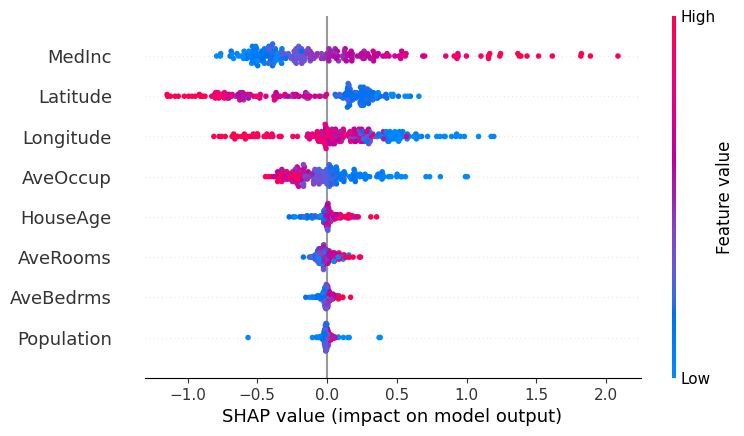

In [91]:
shap.plots.beeswarm(shap_values_test, show=True, max_display=10)

Một lần nữa, chúng ta đang sử dụng trực tiếp `shap_values_test` trong `shap.plots.beeswarm()` mà không sử dụng chỉ mục ở đây.

#### Giải thích Biểu đồ Beeswarm

Giống như biểu đồ beeswarm trong Dự án 1, mỗi chấm nhỏ trong biểu đồ đại diện cho một đặc trưng của một quan sát trong bộ kiểm tra `X_test`. Trục ngang đại diện cho giá trị SHAP của đặc trưng của một quan sát, trong khi màu sắc của mỗi điểm biểu thị mức độ cao (đỏ) hay thấp (xanh lam) của giá trị đặc trưng của quan sát đó, so với giá trị của cùng một đặc trưng ở các quan sát khác.

Các chấm đỏ cho **MedInc** chủ yếu nằm bên phải, với các chấm xanh lam ở bên trái. Điều này có nghĩa là thu nhập trung bình cao hơn trong một nhóm khu dân cư thường đi kèm với giá trị SHAP cao hơn, điều này khiến mô hình dự đoán giá trị nhà trung vị cao hơn trong khu vực.

Ngược lại, các chấm đỏ cho **Latitude** và **Longitude** chủ yếu nằm ở bên trái, với các chấm xanh lam ở bên phải. Như chúng ta biết, **Latitude** cao hơn ở phía bắc và thấp hơn ở phía nam, trong khi **Longitude** cao hơn ở phía đông và thấp hơn ở phía tây. Nhìn chung, biểu đồ beeswarm cho thấy rằng các ngôi nhà nằm ở phía tây nam California có khả năng có giá trị trung vị cao hơn, so với những ngôi nhà nằm ở phía bắc và phía đông, như được dự đoán bởi mô hình.

#### Lưu Biểu đồ Beeswarm

In [92]:
plt.figure()
shap.plots.beeswarm(shap_values_test, show=False, max_display=10)
plt.tight_layout()
plt.savefig('beeswarm_house.pdf')
plt.close()

Một lần nữa, tôi sử dụng `plt.tight_layout()` để ngăn biểu đồ bị kéo dài ra ngoài giới hạn trang. Hãy thoải mái kiểm tra `beeswarm_house.pdf` trong tab Output của notebook Kaggle này.

### Biểu đồ Violin <a class="anchor"  id="violin2"></a>
Biểu đồ violin là một biến thể của biểu đồ beeswarm, hiển thị cùng một thông tin theo cách thẩm mỹ hơn.

#### Mã để Tạo Biểu đồ Violin

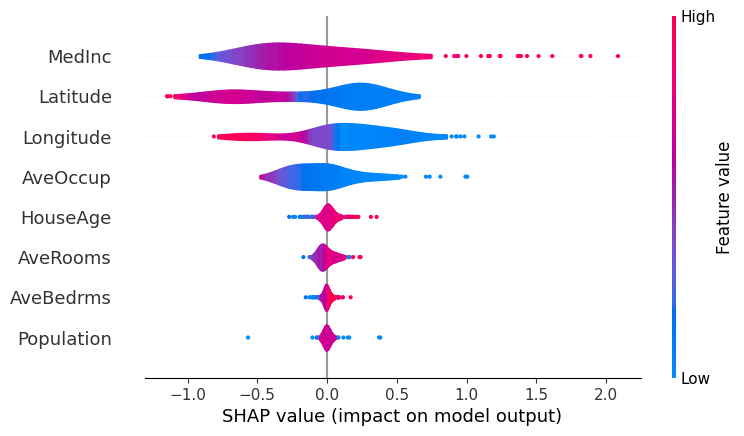

In [93]:
shap.plots.violin(shap_values_test, show=True, max_display=10)

Một lần nữa, có một cách cổ điển để tạo biểu đồ violin:
```python
shap.summary_plot(shap_values_test, show=True, max_display=10, plot_type='violin')
```
, nhưng tôi khuyên bạn nên sử dụng phương pháp mới như trên.

#### Lưu Biểu đồ Violin

In [94]:
plt.figure()
shap.plots.violin(shap_values_test, show=False, max_display=10)
plt.tight_layout()
plt.savefig('violin_house.pdf')
plt.close()

Bằng cách chạy khối mã trên, biểu đồ violin đã được lưu trong thư mục đầu ra dưới tên `violin_house.pdf`.

## Hiển thị SHAP của Một Dự đoán Duy Nhất (Dự án 2) <a class="anchor"  id="single2"></a>

Một lần nữa, như đã tính toán ở trên, mô hình hồi quy của chúng ta dự đoán giá trị trung vị của ngôi nhà trong khu dân cư Elysian Heights là khoảng $309,480. Vậy, những đặc trưng nào đang làm tăng hoặc giảm giá trị ngôi nhà trong khu vực đó?

Cũng như trong Dự án 1, để phân tích tác động tại chỗ và theo từng ví dụ, chúng ta có thể sử dụng biểu đồ cột tại chỗ, biểu đồ thác nước và biểu đồ lực cho quan sát đơn lẻ này.

Nhóm khu dân cư ở khu vực Elysian Heights nằm tại `iloc` 187 (được lưu dưới tên `iloc_test`) trong dataframe `X_test` và mảng giá trị SHAP trong `shap_values_test`. Các giá trị SHAP của nó cũng đã được lưu trong `shap_values_case` một cách riêng biệt. Chúng ta sẽ sử dụng những dữ liệu này để tạo các hình ảnh cho dự đoán duy nhất này.

### Biểu đồ Cột Tại Chỗ <a class="anchor"  id="localbar2"></a>
#### Mã để Tạo Biểu đồ Cột Tại Chỗ

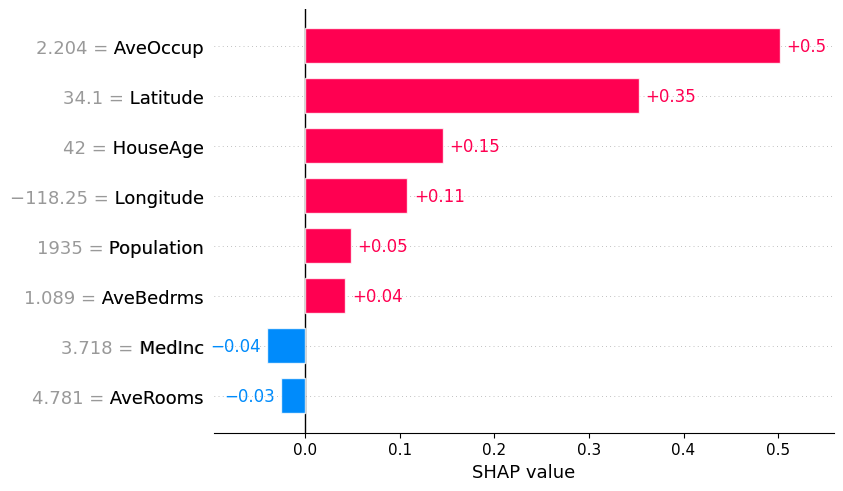

In [95]:
shap.plots.bar(shap_values_test[iloc_test], show=True, max_display=10)

Trong Dự án 1, chúng ta đã sử dụng `shap_values_val_X[row_to_show, :, 1]` trong hàm `shap.plots.bar()` để tạo biểu đồ cột tại chỗ. Nhưng bây giờ, chúng ta không cần chỉ mục chiều thứ ba trong dấu ngoặc vuông sau đối tượng `Explanation` `shap_values_test` vì mảng giá trị SHAP trong `shap_values_test` chỉ là một mảng 2D thay vì một mảng 3D. Mảng giá trị SHAP trong Dự án 1 cần chiều thứ ba để phân biệt ảnh hưởng của đặc trưng làm cho giá trị mục tiêu có khả năng là 1 và ảnh hưởng của nó làm cho giá trị mục tiêu là 0, trong khi mảng giá trị SHAP trong `shap_values_test` ở đây không cần phải phân biệt như vậy, vì các giá trị SHAP của nó luôn chỉ ra ảnh hưởng của đặc trưng lên giá trị mục tiêu dự đoán, tức là giá trị nhà trung vị.

Và một lần nữa, chúng ta cũng có thể sử dụng `shap_values_case`, thay vì `shap_values_test`, để tạo biểu đồ cột tại chỗ, vì `shap_values_case` chỉ chứa các giá trị SHAP cho quan sát duy nhất của nhóm khu dân cư ở khu vực Elysian Heights. Kích thước của mảng trong `shap_values_case` là (1, 8), vì vậy chúng ta chỉ cần chỉ mục `[0]` để lấy phần tử duy nhất trong `shap_values_case`:

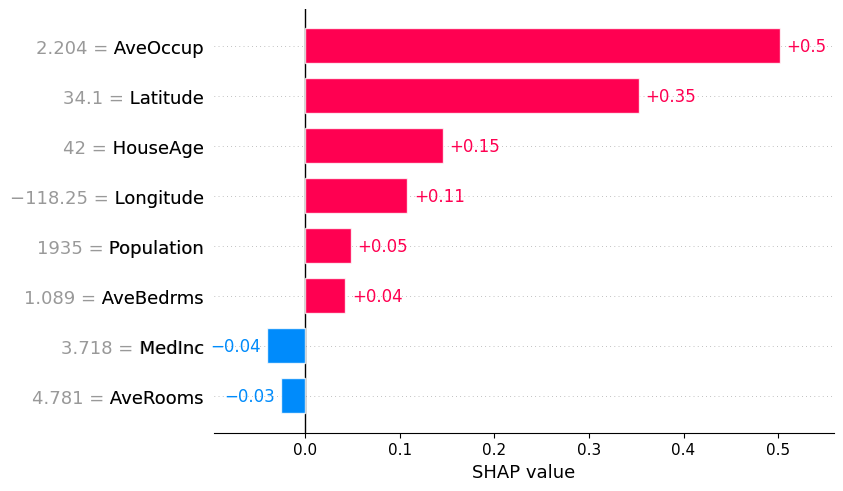

In [96]:
shap.plots.bar(shap_values_case[0], show=True, max_display=10)

Thật thú vị, nếu chúng ta quên không đặt chỉ mục `[0]` sau `shap_values_case` ở trên, nó sẽ tự động tạo ra một biểu đồ cột hiển thị các giá trị SHAP **tuyệt đối** của mỗi đặc trưng trong dự đoán duy nhất này.

#### Giải thích Biểu đồ Cột Tại Chỗ

Ngạc nhiên thay, yếu tố có ảnh hưởng lớn nhất đến giá trị nhà trung vị của nhóm khu dân cư ở Elysian Heights là **AveOccup**, số lượng trung bình thành viên trong mỗi hộ gia đình, theo biểu đồ cột tại chỗ. **AveOccup** không có vẻ là yếu tố có ảnh hưởng lớn như vậy trong biểu đồ cột toàn cầu hay biểu đồ beeswarm ở trên. Trong khi đó, mặc dù **MedInc** (thu nhập trung bình) là đặc trưng quan trọng nhất trong biểu đồ cột toàn cầu và biểu đồ beeswarm, nó lại là yếu tố có ảnh hưởng ít thứ hai đối với giá trị nhà trung vị ở Elysian Heights.

Trường hợp này cho chúng ta thấy tầm quan trọng của việc có cái nhìn sâu sắc về các dự đoán của mô hình theo từng trường hợp cụ thể. Một biến có ảnh hưởng toàn cầu có thể không phải là yếu tố ảnh hưởng chính trong một ví dụ cụ thể. Để giải quyết một vấn đề cụ thể, việc phân tích các khía cạnh đặc biệt và quan trọng của tình huống chính xác là điều không thể thiếu.

Một nhược điểm chính của biểu đồ cột tại chỗ là thiếu thông tin về giá trị các đặc trưng. Nó không cho chúng ta biết số lượng thành viên trung bình trong hộ gia đình **AveOccup** ở Elysian Heights, mặc dù nó hiển thị giá trị SHAP **+0.5** của đặc trưng này trong quan sát này. Xét rằng biến mục tiêu được biểu diễn bằng 100,000 USD, chúng ta có thể nói rằng số lượng thành viên trung bình trong hộ gia đình ở Elysian Heights làm tăng giá trị nhà trung vị dự đoán trong khu vực này khoảng 50,000 USD.

Mặc dù có thể thu thập dữ liệu về **AveOccup** từ `neighborhood_row` và `X_test` cho quan sát này, chúng ta hãy thử trả lời câu hỏi này với biểu đồ thác nước dưới đây.

#### Lưu Biểu đồ Cột Tại Chỗ

In [97]:
plt.figure()
shap.plots.bar(shap_values_test[iloc_test], show=False, max_display=10)
plt.tight_layout()
plt.savefig('local_bar_house.pdf')
plt.close()

Bằng cách chạy khối mã trên, biểu đồ cột tại chỗ đã được lưu trong thư mục đầu ra dưới tên `local_bar_house.pdf`.

### Biểu đồ Thác Nước <a class="anchor"  id="water2"></a>

#### Mã để Tạo Biểu đồ Thác Nước

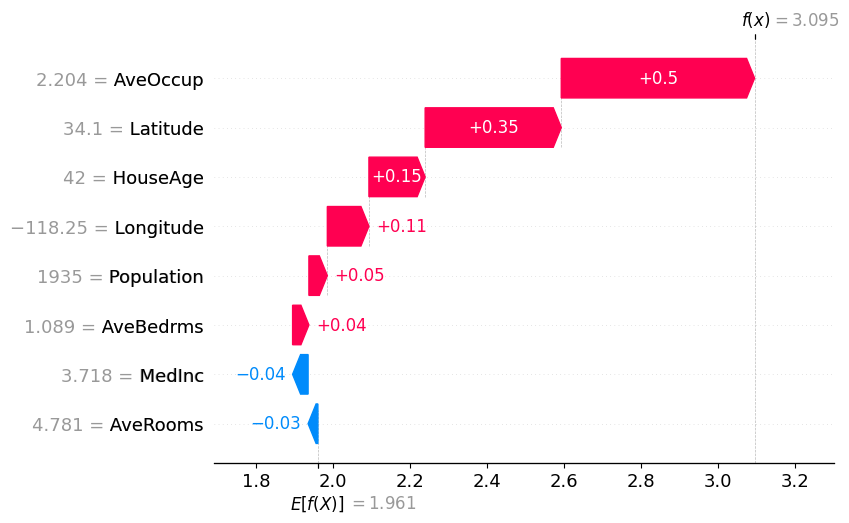

In [98]:
shap.plots.waterfall(shap_values_test[iloc_test], show=True, max_display=10)

Và giống như biểu đồ cột tại chỗ ở trên, chúng ta có thể sử dụng `shap_values_test` hoặc `shap_values_case` để tạo biểu đồ thác nước, miễn là chúng ta gán chỉ mục chính xác cho nhóm khu dân cư ở Elysian Heights:

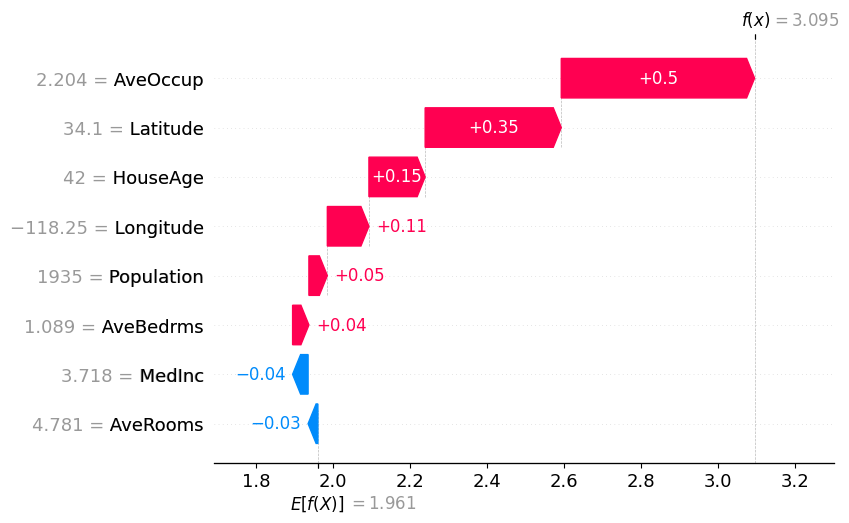

In [99]:
shap.plots.waterfall(shap_values_case[0], show=True, max_display=10)

#### Giải thích Biểu đồ Thác Nước

Theo biểu đồ thác nước ở trên, số lượng thành viên trung bình trong hộ gia đình **AveOccup** trong nhóm khu dân cư ở Elysian Heights là 2.204, điều này làm tăng giá trị mục tiêu dự đoán lên 0.5 (tăng 50,000 USD trong giá trị nhà trung vị). Chúng ta có thể xác nhận điều này với dữ liệu gốc:

In [100]:
case_AveOccup = neighborhood_row.AveOccup.iloc[0]
print('The average number of household members in the block group of Elysian Heights is {:.3f}.'.format(case_AveOccup))

The average number of household members in the block group of Elysian Heights is 2.204.


Mô hình của chúng ta có coi số lượng thành viên trong hộ gia đình này ở Elysian Heights là quá lớn hay quá nhỏ không? Với tôi, nó có vẻ nhỏ khi nhìn lần đầu, nhưng chúng ta có thể kiểm tra điều này bằng cách so sánh nó với các dữ liệu khác trong bộ dữ liệu huấn luyện mà mô hình đã được xây dựng.

In [101]:
# Remove extreme outliers in X_train
X_train_AveOccup_regular = X_train.loc[X_train.AveOccup < X_train.AveOccup.quantile(0.99)].AveOccup
print(X_train_AveOccup_regular.describe())

count    20228.000000
mean         2.888687
std          0.694061
min          0.692308
25%          2.425981
50%          2.810293
75%          3.264027
max          5.396000
Name: AveOccup, dtype: float64


Ngay cả sau khi loại bỏ các ngoại lệ cực đoan trên phân vị 99 của **AveOccup**, giá trị trung bình và trung vị vẫn cao như 2.89 và 2.81 trong bộ dữ liệu `X_train`. Giá trị **AveOccup** ở Elysian Heights là 2.204, thậm chí còn thấp hơn phân vị 25 là 2.426. Chúng ta có thể kết luận rằng số lượng thành viên trung bình trong hộ gia đình ở nhóm khu dân cư Elysian Heights là quá nhỏ, so với các khu vực khác của California.

Chúng ta có thể trực quan hóa điều này với một đường cong mật độ phân phối:

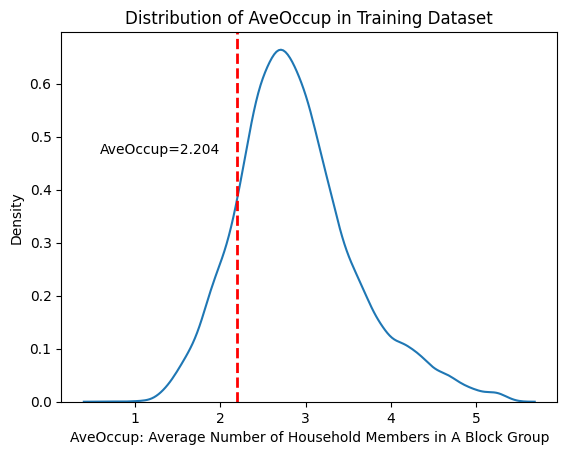

In [102]:
sns.kdeplot(X_train_AveOccup_regular)
plt.axvline(x=case_AveOccup, color='red', linestyle='--', linewidth=2)

# Add annotation to the vertical line
y_max = plt.gca().get_ylim()[1]  # Get the maximum y value of the plot
plt.annotate(
    'AveOccup={:.3f}'.format(case_AveOccup),
    xy=(case_AveOccup, y_max),
    xytext=(round(case_AveOccup), 0.7*y_max),
    ha='right',
    va='top')

plt.title('Distribution of AveOccup in Training Dataset')
plt.xlabel('AveOccup: Average Number of Household Members in A Block Group')
plt.ylabel('Density')
plt.show()

Rõ ràng, số lượng thành viên trung bình trong hộ gia đình ở nhóm khu dân cư Elysian Heights nhỏ hơn so với hầu hết các nhóm khu dân cư khác ở California.

Vậy tại sao nó lại có giá trị SHAP dương **+0.5**? Bằng cách kiểm tra biểu đồ beeswarm ở trên, chúng ta biết rằng điều này phù hợp với xu hướng tổng thể: Các giá trị **AveOccup** cao hơn có liên quan đến các giá trị SHAP thấp hơn, trong khi các giá trị **AveOccup** thấp hơn lại chỉ ra các giá trị SHAP cao hơn. Vì vậy, mô hình của chúng ta dự đoán rằng kích thước hộ gia đình nhỏ ở Elysian Heights có khả năng làm tăng giá trị nhà trung vị thêm 50,000 USD trong khu vực (mặc dù điều này có thể không phải là một mối quan hệ nhân quả trực tiếp).

Và một lần nữa, một lợi thế khác của biểu đồ thác nước là chúng ta có thể thấy rõ ràng cách mà tổng tất cả các giá trị SHAP của các đặc trưng bằng với sự chênh lệch giữa dự đoán _f(x)_ (3.095) cho quan sát duy nhất và giá trị kỳ vọng _E[f(x)]_ (1.961) cho tình huống trung bình trong dữ liệu huấn luyện. Nói cách khác, giá trị nhà trung vị trung bình cho các quận ở California là khoảng 196,100 USD, nhưng các đặc điểm của thị trường bất động sản ở Elysian Heights làm tăng giá trị nhà trung vị của nó lên khoảng 309,500 USD, như được mô hình dự đoán.

#### Lưu Biểu đồ Thác Nước

In [103]:
plt.figure()
shap.plots.waterfall(shap_values_test[iloc_test], show=False, max_display=10)
plt.tight_layout()
plt.savefig('waterfall_house.pdf')
plt.close()

Bằng cách chạy khối mã trên, biểu đồ thác nước đã được lưu trong thư mục đầu ra dưới tên `waterfall_house.pdf`.

### Biểu đồ Lực <a class="anchor"  id="force2"></a>
Biểu đồ lực là một cách khác để xem ảnh hưởng của mỗi đặc trưng đối với dự đoán của một quan sát cụ thể, ví dụ như giá trị nhà trung vị trong nhóm khu dân cư Elysian Heights.

#### Mã để Tạo Biểu đồ Lực

In [104]:
shap.initjs()
shap.plots.force(shap_values_test[iloc_test])

Một đặc điểm của biểu đồ lực là việc sử dụng `shap.initjs()` để khởi tạo các hình ảnh JavaScript trong môi trường notebook (ví dụ như Jupyter notebooks), mặc dù điều này không áp dụng khi chạy trong IDE (ví dụ như Pycharm).

Nếu bạn thay thế `shap_values_test[iloc_test]` bằng `shap_values_case[0]` trong các mã, nó cũng sẽ hoạt động:

In [105]:
shap.plots.force(shap_values_case[0])

#### Giải thích Biểu đồ Lực

* Giá trị được làm nổi bật **3.09** dưới f(x) là dự đoán cho quan sát này. Nói cách khác, mô hình của chúng ta dự đoán rằng giá trị nhà trung vị trong nhóm khu dân cư Elysian Heights là khoảng 309,000 USD.

* Giá trị cơ sở **1.961** (khoảng 196,100 USD) là giá trị nhà trung vị kỳ vọng cho một quận ngẫu nhiên ở California nói chung.

* Hầu hết các đặc trưng của quan sát này được hiển thị bằng màu đỏ ở bên trái, có nghĩa là chúng đang đẩy giá trị mục tiêu dự đoán f(x) cao hơn đáng kể so với giá trị cơ sở. Các đặc trưng có giá trị SHAP dương lớn nhất là **AveOccup**, **Latitude** và **HouseAge**.

* Giá trị SHAP âm rất nhỏ từ **MedInc** gần như không đáng kể trong trường hợp này, khi thu nhập trung bình trong nhóm khu dân cư là khoảng 37,180 USD.

#### Lưu Biểu đồ Lực

In [106]:
force_plot_house = shap.plots.force(shap_values_test[iloc_test], show=False)
shap.save_html('force_plot_house.htm', force_plot_house)

Bằng cách chạy khối mã trên, biểu đồ lực đã được lưu trong thư mục đầu ra dưới tên `force_plot_house.htm`. Nó hoạt động cả trong notebooks và IDEs (ví dụ như PyCharm). Và tất nhiên, bạn cũng có thể nhận được cùng một tệp đầu ra bằng cách sử dụng `shap_values_case` trong các mã:
```python
force_plot_house = shap.plots.force(shap_values_case[0], show=False)
```
Một lựa chọn thứ hai để lưu biểu đồ lực cục bộ là vào định dạng PDF với `matplotlib`:

In [107]:
plt.close()

In [108]:
plt.figure(figsize=(40, 10))
shap.plots.force(shap_values_test[iloc_test], matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('force_plot_house.pdf')
plt.close()

Giá trị mặc định của tham số `matplotlib` trong dấu ngoặc của `shap.plots.force` là `False`, vì đầu ra `matplotlib` của biểu đồ lực không đẹp mắt bằng đầu ra Javascript mặc định ở định dạng `htm`. Bạn có thể kiểm tra chúng trong tab Output của notebook Kaggle này. Việc thiết lập `matplotlib=True` ở đây chỉ hữu ích trong các trường hợp mà đầu ra Javascript/HTML không được chấp nhận.

### Bonus: Biểu đồ Phụ Thuộc Một Phần <a class="anchor"  id="pdp2"></a>
Vì bạn đã đến đây, có thể bạn đang tự hỏi tại sao **MedInc** có vẻ có ảnh hưởng lớn hơn nhiều so với **AveOccup** trong biểu đồ beeswarm, nhưng tình huống của chúng lại đảo ngược trong biểu đồ thác nước và biểu đồ lực đối với quan sát duy nhất mà chúng ta đang nghiên cứu. Để trả lời câu hỏi này, sẽ rất tốt nếu biết thu nhập trung vị trong nhóm khu dân cư Elysian Heights là bao nhiêu, và nó so sánh như thế nào với các nhóm khu dân cư khác ở California.

In [109]:
case_MedInc = neighborhood_row.MedInc.iloc[0]
print('The median income of the block group in Elysian Heights is {:.3f}, which means around ${:,.0f}.\n'.format(case_MedInc, case_MedInc*10000))
print('The distribution of median income levels of all block groups in the training dataset:')
print(X_train.MedInc.describe())

The median income of the block group in Elysian Heights is 3.718, which means around $37,184.

The distribution of median income levels of all block groups in the training dataset:
count    20433.000000
mean         3.871841
std          1.901974
min          0.499900
25%          2.565200
50%          3.535300
75%          4.742600
max         15.000100
Name: MedInc, dtype: float64


Như đã thấy trong các số liệu trên, **MedInc** của quan sát này là 3.718, rất gần với giá trị trung bình (3.872) và trung vị (3.535) trong bộ dữ liệu huấn luyện. Vì vậy, dễ hiểu khi **MedInc** không có nhiều ảnh hưởng đến sự khác biệt giữa giá trị mục tiêu dự đoán của quan sát cụ thể này và giá trị trung bình tổng thể (giá trị cơ sở).

Biểu đồ phụ thuộc một phần là một cách tuyệt vời để trực quan hóa sự tương tác giữa phản hồi mục tiêu và một tập hợp các đặc trưng đầu vào quan tâm. Chúng ta có thể minh họa tốt hơn sự tổng hợp các ảnh hưởng từ **MedInc** và **AveOccup** bằng một biểu đồ phụ thuộc một phần hai chiều:

<Figure size 4000x1000 with 0 Axes>

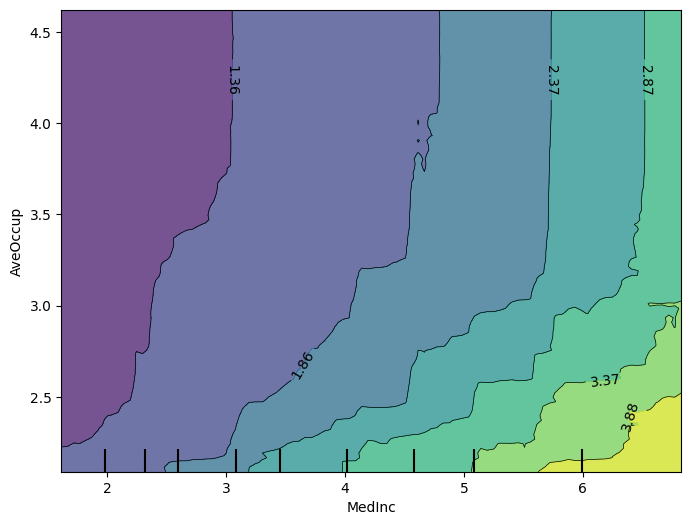

In [110]:
fig, ax = plt.subplots(figsize=(8, 6))
disp_medinc_aveoccup = PartialDependenceDisplay.from_estimator(estimator=model, X=X_test, features=[('MedInc', 'AveOccup')], ax=ax)
plt.show()

Tương tự như biểu đồ beeswarm, biểu đồ phụ thuộc một phần này cũng cho thấy cách mà **MedInc** và **AveOccup** ảnh hưởng đến dự đoán của mô hình trên bộ dữ liệu `X_test`. Mặc dù **MedInc** có ảnh hưởng, nhưng nó không thể tự mình quyết định kết quả dự đoán. Khi thu nhập trung vị trong một nhóm khu dân cư ở mức trung bình, một **AveOccup** thấp hơn đáng kể (số lượng thành viên hộ gia đình ít hơn) sẽ ám chỉ giá trị nhà trung vị cao hơn cho quận đó ở California.